<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Embeddings

Привет! В этом домашнем задании мы с помощью эмбеддингов решим задачу семантической классификации твитов.

Для этого мы воспользуемся предобученными эмбеддингами word2vec.

Для начала скачаем датасет для семантической классификации твитов:

In [1]:
!gdown https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph&export=download
!unzip archive.zip

Downloading...
From: https://drive.google.com/uc?id=1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph
To: /content/archive.zip
100% 84.9M/84.9M [00:00<00:00, 107MB/s] 
Archive:  archive.zip
  inflating: training.1600000.processed.noemoticon.csv  


Импортируем нужные библиотеки:

In [2]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import nltk
import gensim
import gensim.downloader as api

In [3]:
import os
import torch.nn as nn

from IPython.display import clear_output
from time import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

In [4]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin", header=None, names=["emotion", "id", "date", "flag", "user", "text"])

Посмотрим на данные:

In [6]:
data.head()

,emotion,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.emotion.value_counts()

0    800000
4    800000
Name: emotion, dtype: int64

Выведем несколько примеров твитов, чтобы понимать, с чем мы имеем дело:

In [7]:
examples = data["text"].sample(10)
print("\n".join(examples))

@chrishasboobs AHHH I HOPE YOUR OK!!! 
@misstoriblack cool , i have no tweet apps  for my razr 2
@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
upper airways problem 
Going to miss Pastor's sermon on Faith... 
on lunch....dj should come eat with me 
@piginthepoke oh why are you feeling like that? 
gahh noo!peyton needs to live!this is horrible 
@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!


Как видим, тексты твитов очень "грязные". Нужно предобработать датасет, прежде чем строить для него модель классификации.

Чтобы сравнивать различные методы обработки текста/модели/прочее, разделим датасет на dev(для обучения модели) и test(для получения качества модели).

In [8]:
indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
dev_size = math.ceil(data.shape[0] * 0.8)

dev_indexes = indexes[:dev_size]
test_indexes = indexes[dev_size:]

dev_data = data.iloc[dev_indexes]
test_data = data.iloc[test_indexes]

dev_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print('Размер dev данных: ', dev_data.shape)
print('Размер test данных: ', test_data.shape)

Размер dev данных:  (1280000, 6)
Размер test данных:  (320000, 6)


## Обработка текста

Токенизируем текст, избавимся от знаков пунктуации и выкинем все слова, состоящие менее чем из 4 букв:

In [9]:
tokenizer = nltk.WordPunctTokenizer()
line = tokenizer.tokenize(dev_data["text"][0].lower())
print(" ".join(line))

@ claire_nelson i ' m on the north devon coast the next few weeks will be down in devon again in may sometime i hope though !


In [10]:
filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
print(" ".join(filtered_line))

north devon coast next weeks will down devon again sometime hope though


Загрузим предобученную модель эмбеддингов. 

Если хотите, можно попробовать другую. Полный список можно найти здесь: https://github.com/RaRe-Technologies/gensim-data.

Данная модель выдает эмбеддинги для **слов**. Строить по эмбеддингам слов эмбеддинги предложений мы будем ниже.

In [11]:
word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/DLS_NLP/2w_embeddings/'
os.makedirs(DATA_DIR, exist_ok = True) 

In [ ]:
# Сохраним модель, чтобы в следующий раз быстрее загружать
import pickle
with open(os.path.join(DATA_DIR, 'word2vec_google.pickle'), 'wb') as handle:
    pickle.dump(word2vec, handle)

In [ ]:
# Загрузим word2vec
import pickle
with open(os.path.join(DATA_DIR, 'word2vec_google.pickle'), 'rb') as handle:
    word2vec = pickle.load(handle)

In [12]:
emb_line = [word2vec.get_vector(w) for w in filtered_line if w in word2vec]
print(sum(emb_line).shape)
print(filtered_line)
print(len(filtered_line), len(emb_line))

(300,)
['north', 'devon', 'coast', 'next', 'weeks', 'will', 'down', 'devon', 'again', 'sometime', 'hope', 'though']
12 12


Нормализуем эмбеддинги, прежде чем обучать на них сеть. 
(наверное, вы помните, что нейронные сети гораздо лучше обучаются на нормализованных данных)

In [13]:
mean = np.mean(word2vec.vectors, 0)
std = np.std(word2vec.vectors, 0)
norm_emb_line = [(word2vec.get_vector(w) - mean) / std for w in filtered_line if w in word2vec and len(w) > 3]
print(sum(norm_emb_line).shape)
print([all(norm_emb_line[i] == emb_line[i]) for i in range(len(emb_line))])

(300,)
[False, False, False, False, False, False, False, False, False, False, False, False]


Сделаем датасет, который будет по запросу возвращать подготовленные данные.

In [16]:
from torch.utils.data import Dataset, random_split


class TwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}

    def get_tokens_(self, text):
        # Получи все токены из текста и профильтруй их
        line = self.tokenizer.tokenize(text.lower())
        filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]

        return filtered_line

    def get_embeddings_(self, tokens):
        # Получи эмбеддинги слов и усредни их
        ## Выполнено с учетом того, что в функцию приходят токены из self.get_tokens_
        embeddings = [(self.word2vec.get_vector(w) - self.mean) / self.std for w in tokens if w in self.word2vec] 

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [17]:
dev = TwitterDataset(dev_data, "text", "emotion", word2vec)

In [18]:
len(dev), dev.feature_column, dev.target_column

(1280000, 'text', 'emotion')

Отлично, мы готовы с помощью эмбеддингов слов превращать твиты в векторы и обучать нейронную сеть.

Превращать твиты в векторы, используя эмбеддинги слов, можно несколькими способами. А именно такими:

## Average embedding (2 балла)
---
Это самый простой вариант, как получить вектор предложения, используя векторные представления слов в предложении. А именно: вектор предложения есть средний вектор всех слов в предлоежнии (которые остались после токенизации и удаления коротких слов, конечно). 

In [ ]:
# indexes = np.arange(len(dev))
# np.random.shuffle(indexes)
# example_indexes = indexes[::1000]

# examples = {"features": [np.sum(dev[i]["feature"], axis=0) for i in example_indexes], 
#             "targets": [dev[i]["target"] for i in example_indexes]}
# print(len(examples["features"]))

In [19]:
indexes = np.arange(len(dev))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.mean(dev[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


Давайте сделаем визуализацию полученных векторов твитов тренировочного (dev) датасета. Так мы увидим, насколько хорошо твиты с разными target значениями отделяются друг от друга, т.е. насколько хорошо усреднение эмбеддингов слов предложения передает информацию о предложении.

Для визуализации векторов надо получить их проекцию на плоскость. Сделаем это с помощью `PCA`. Если хотите, можете вместо PCA использовать TSNE: так у вас получится более точная проекция на плоскость (а значит, более информативная, т.е. отражающая реальное положение векторов твитов в пространстве). Но TSNE будет работать намного дольше.

In [20]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
# Обучи PCA на эмбеддингах слов
examples["transformed_features"] = pca.fit_transform(examples['features'])

In [21]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [22]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1003', ...)

Скорее всего, на визуализации нет четкого разделения твитов между классами. Это значит, что по полученным нами векторам твитов не так-то просто определить, к какому классу твит пренадлежит. Значит, обычный линейный классификатор не очень хорошо справится с задачей. Надо будет делать глубокую (хотя бы два слоя) нейронную сеть.

Подготовим загрузчики данных.
Усреднее векторов будем делать в "батчевалке"(`collate_fn`). Она используется для того, чтобы собирать из данных `torch.Tensor` батчи, которые можно отправлять в модель.


In [ ]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 2

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.FloatTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)

train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

Определим функции для тренировки и теста модели:

In [ ]:
DATA_DIR = '/content/drive/MyDrive/DLS_NLP/2w_embeddings/'

In [ ]:
from tqdm.notebook import tqdm

def training(model, optimizer, criterion, train_loader, epoch, device="cpu"):   
    running_loss = 0.0
    running_acc = 0.0   

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}. Train Loss: {0}. Train Accuracy: {0}")
    model.train()
    for batch in pbar:
        features = batch["features"].to(device)
        targets = batch["targets"].to(device)

        # Получи предсказания модели
        outputs = model(features)
        # Посчитай лосс
        loss = criterion(outputs.flatten(), targets)
        # Обнови параметры модели
        loss.backward()
        optimizer.step()

        preds = outputs.detach().cpu().flatten() > 0.5
        running_loss += loss.item()
        batch_acc = ((preds == targets.cpu()).sum() / targets.size(0)).item()
        running_acc += batch_acc

        optimizer.zero_grad()   
        pbar.set_description(f"Epoch {epoch}. Train Loss: {loss.item():.4}. Train Acc: {batch_acc:.4}")     
    
    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    pbar.set_description(f"Epoch {epoch}. Train Loss: {train_loss:.4}. Train Acc: {train_acc:.4}")

    return {"Train Loss": train_loss, "Train Acc": train_acc}
    

def testing(model, criterion, test_loader, device="cpu"):
    running_loss = 0.0
    running_acc = 0.0   

    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")
    model.eval()
    with torch.no_grad():
        for batch in pbar:
            features = batch["features"].to(device)
            targets = batch["targets"].to(device)

            # Получи предсказания модели
            outputs = model(features)
            # Посчитай лосс
            loss = criterion(outputs.flatten(), targets)
            # Посчитай точность модели
            preds = outputs.detach().cpu().flatten() > 0.5
            running_loss += loss.item()
            batch_acc = ((preds == targets.cpu()).sum() / targets.size(0)).item()
            running_acc += batch_acc
            pbar.set_description(f"Test Loss: {loss.item():.4}, Test Acc: {batch_acc:.4}")
    
    test_loss = running_loss / len(test_loader)
    test_acc = running_acc / len(test_loader)
    pbar.set_description(f"Test Loss: {test_loss:.4}, Test Acc: {test_acc:.4}")

    return {"Test Loss": test_loss, "Test Acc": test_acc}


def fit_model(model, optimizer, criterion, train_loader, valid_loader, epochs, model_name, device="cpu", start=1):
    since = time()
    best_acc = 0
    best_epoch = 0
    best_time = 0
    dict_metrics = {
        'train_loss': [],
        'train_ac': [],
        'val_loss': [],
        'val_ac': []
    }

    log_template = "\nEpoch {ep:03d}  train_loss: {t_loss:0.4f} \
     val_loss {v_loss:0.4f}  train_ac {t_ac:0.4f}  val_ac {v_ac:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            # train and val
            t_dct = training(model, optimizer, criterion, train_loader, epoch+start, device)                    
            v_dct = testing(model, criterion, valid_loader, device)

            # save history for graphs
            dict_metrics['train_loss'].append(t_dct["Train Loss"])
            dict_metrics['train_ac'].append(t_dct["Train Acc"])
            dict_metrics['val_loss'].append(v_dct["Test Loss"])
            dict_metrics['val_ac'].append(v_dct["Test Acc"])

            # save best model
            if v_dct["Test Acc"] > best_acc:
                best_acc= v_dct["Test Acc"]
                torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '_model.pt'))
                best_epoch = epoch
                best_time = time() - since

            # save current model
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '_model.pt'))

            # Visualize tools
            clear_output(wait=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+start+1, 
                                           t_loss=t_dct["Train Loss"], 
                                           v_loss=v_dct["Test Loss"], 
                                           t_ac=t_dct["Train Acc"], 
                                           v_ac=v_dct["Test Acc"])
                      )
            plt.figure(figsize=(24, 9))       
            plt.subplot(1,2,1)
            plt.plot(dict_metrics['train_loss'], label="train_loss")
            plt.plot(dict_metrics['val_loss'], label="val_loss")
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.ylabel("loss")            
            plt.subplot(1,2,2)
            plt.plot(dict_metrics['train_ac'], label="train_ac")
            plt.plot(dict_metrics['val_ac'], label="val_ac")
            plt.legend(loc='best')
            plt.xlabel("epochs")
            plt.ylabel("accuracy")
            
            plt.suptitle(f"Last Loss {round(dict_metrics['val_loss'][-1], 4)}. Last metric {round(dict_metrics['val_ac'][-1], 4)}", fontsize=16)
            plt.show()

    # load best model
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '_model.pt')))
    
    return model, dict_metrics

In [ ]:
class E2CModel(nn.Module):
    def __init__(self, vector_size, num_classes):
        super().__init__()
        self.linear = nn.Sequential(
             nn.Linear(vector_size, int(vector_size / 2), bias=False),
             nn.ReLU(),
             nn.Linear(int(vector_size / 2), int(vector_size / 4), bias=False),
             nn.ReLU(),
             nn.Linear(int(vector_size / 4), int(vector_size / 16), bias=False),
             nn.ReLU(),
             nn.Linear(int(vector_size / 16), num_classes-1, bias=False)
        )
        self.vector_size = vector_size
        self.num_classes = num_classes
        self.activate = nn.Sigmoid()

    def forward(self, x):
        return self.activate(self.linear(x))

Создадим модель, оптимизатор и целевую функцию. Вы можете сами выбрать количество слоев в нейронной сети, ваш любимый оптимизатор и целевую функцию.


In [ ]:
import torch.nn as nn
from torch.optim import Adam


# Не забудь поиграться с параметрами ;)
vector_size = dev.word2vec.vector_size
num_classes = 2
lr = 1e-3
epochs = 10
model_name = 'w2v'

model = E2CModel(vector_size, num_classes)
model = model.to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = Adam(params=model.parameters(), lr=lr)

Наконец, обучим модель и протестируем её.

После каждой эпохи будем проверять качество модели на валидационной части датасета. Если метрика стала лучше, будем сохранять модель. **Подумайте, какая метрика (точность или лосс) будет лучше работать в этой задаче?** 

Комментарий:

* Функция ниже закомментирована, так как выше я написала фукнцию, которая каждую эпоху учится, валидируется и сохраняет лучшую (по accuracy) и последнюю модель.
* Касательно метрики, я выбирала лучшую модель по accuracy на валидации, так как в данной задаче не имеет принципиального значения, ориентироваться по Loss или Accuracy. Их значения имеют обратную корреляцию (см. графики ниже). Т.е. чем ниже Loss, тем выше Accuracy. Диапазон изменения этих метрик небольшой, а лучшие показатели $\pm$ достигаются на одной или близких эпохах.
Accuracy я считала по порогу 0.5. Т.е. все значения предсказаний, выше 0.5 становятся 1 классом, а ниже - 0 классом.
* Чтобы сравнить accuracy и Loss, лучше обратиться к формулам:
$$Ac = \frac{\sum_i^N([\hat{y_i} > 0.5] == y_i)}{N}$$
где, 
  * $\hat{y_i}$ - вероятность принадлежности к классу 1 для $i$-ого сэмпла
  * $y_i$ - фактический класс $i$-ого сэмпла
  * $N$ - количество сэмплов

Т.е. если модель права, то не имеет значения, насколько она уверена. Для вероятности 0.51 и 0.99 будут одинаковые значения для $i$-ого сэмпла. И если модель ошибается, то не имеет значения, насколько уверенно она ошибается.

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\hat y_i + (1-y_i)\log(1-\hat y_i)\right].$$

LogLoss же учитывает фактическое, а не порогое предсказание модели, которое влияет на значение под логарифмом, а значит, модель, которая уверенно ошибается будет хуже модели, которая ошибается с меньшей уверенностью. И модель, которая уверенно права, будет лучше модели, которая права, но не уверена в этом.

Поэтому, если бы Loss и Accuracy изменялись бы в более широкий диапазонах (или я бы обучала модель для конкретных практических целей), я бы ориентировалась на Loss (только на средний лосс по батчу, а не на суммарный, как в моей реализации).

In [ ]:
# best_metric = np.inf
# for e in range(num_epochs):
#     training(model, optimizer, criterion, train_loader, e, device)
#     log = testing(model, criterion, valid_loader, device)
#     print(log)
#     if log["Test Loss"] < best_metric:
#         torch.save(model.state_dict(), "model.pt")
#         best_metric = log["Test Loss"]


Epoch 011  train_loss: 481.6064      val_loss 506.5740  train_ac 0.7700  val_ac 0.7556


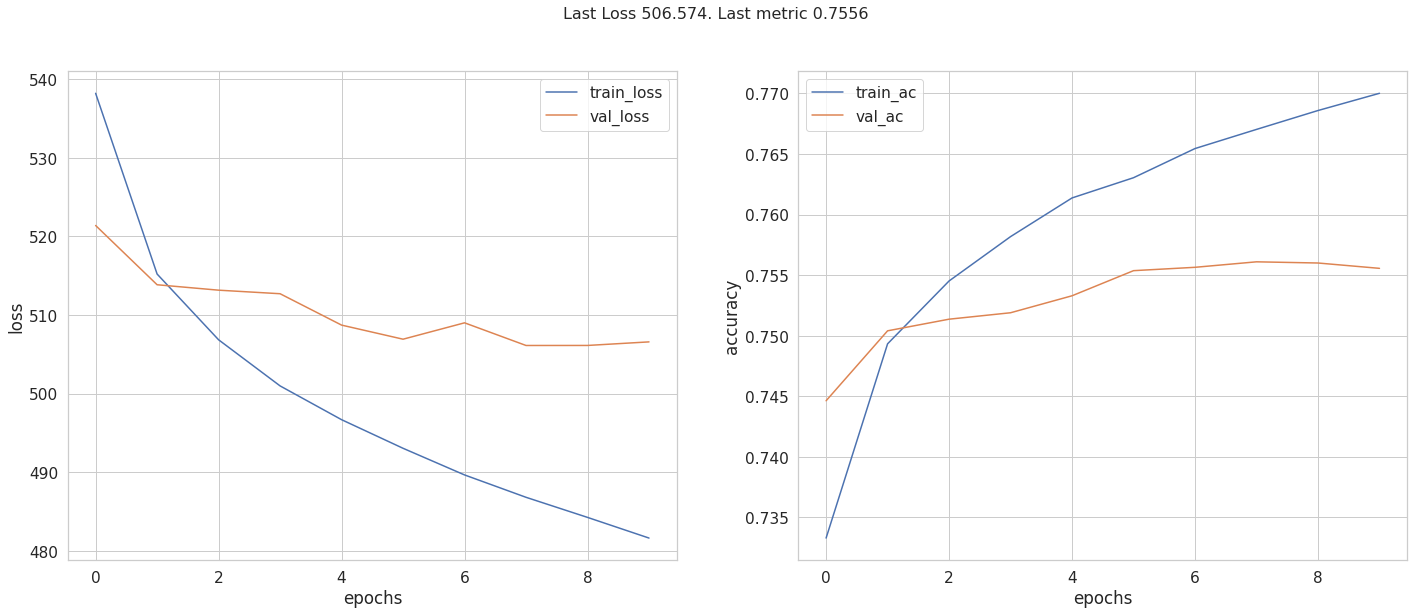

In [ ]:
model, dict_metrics = fit_model(model, optimizer, criterion, train_loader, valid_loader, epochs, model_name, device, start=1)

In [ ]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

# model.load_state_dict(torch.load("model.pt", map_location=device))
model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_model.pt')))

print(testing(model, criterion, test_loader, device=device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


{'Test Loss': 505.1835560174034, 'Test Acc': 0.7559779353035144}


## Embeddings for unknown words (8 баллов)

Пока что использовалась не вся информация из текста. Часть информации фильтровалось – если слова не было в словаре эмбеддингов, то мы просто превращали слово в нулевой вектор. Хочется использовать информацию по-максимуму. Поэтому рассмотрим другие способы обработки слов, которых нет в словаре. А именно:

- Для каждого незнакомого слова будем запоминать его контекст(слова слева и справа от этого слова). Эмбеддингом нашего незнакомого слова будет сумма эмбеддингов всех слов из его контекста. (4 балла)
- Для каждого слова текста получим его эмбеддинг из Tfidf с помощью ```TfidfVectorizer``` из [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Итоговым эмбеддингом для каждого слова будет сумма двух эмбеддингов: предобученного и Tfidf-ного. Для слов, которых нет в словаре предобученных эмбеддингов, результирующий эмбеддинг будет просто полученный из Tfidf. (4 балла)

Реализуйте оба варианта **ниже**. Напишите, какой способ сработал лучше и ваши мысли, почему так получилось.

### Эмбеддинг по контексту

- Создадим словарь для незнакомых слов. Ключ - слово, значение - средний эмбеддинг всех слов, с которыми это слово находится в одном предложении
- Добавим изменение в функцию get_embeddings_ - если слова нет в word2vec, будем искать его в словаре незнакомых слов
- Сделаем такой словарь только для dev_data и будем применять его к test_data. В боевых условиях возможно у запрашиваемого слова не будет контекта, или на вход будет подаваться только 1 предложение.

In [ ]:
def get_unknown_embeddings(data, feature_column, word2vec):
    tokenizer = nltk.WordPunctTokenizer()
    dct_unknown = dict()
    #Запускаем цикл по текстам data
    for text in data[feature_column].to_list():
        # Получаем токены
        line = tokenizer.tokenize(text.lower())
        filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
        # Если в списке токенов больше 1 слова (т.е. есть контекст), запускаем цикл по словам в токенах
        if len(filtered_line) > 1:
            for w in filtered_line:
                # Если слова нет в модели, проверяем наличие эмбеддингов в word2vec
                if w not in word2vec:
                    lst_words = [w for w in filtered_line if w in word2vec]
                    # Если хотя бы у одного слова из контекста нашелся эмбеддинг, пополняем словарь
                    if len(lst_words):
                        if w not in dct_unknown:
                            dct_unknown[w] = []
                        dct_unknown[w].extend(lst_words)

    # таким образом, в словаре будут содержаться только те слова, у контекста которых есть эмбеддинги.
    # Получим средний эмбеддинг неизвестного слова из контекста
    for w, context in dct_unknown.items():
        embeddings = [word2vec.get_vector(w) for w in context]
        mean_emb = np.mean(embeddings, axis=0)
        dct_unknown[w] = mean_emb
    
    return dct_unknown

unknown_embeddings = get_unknown_embeddings(dev_data, 'text', word2vec)

In [ ]:
# Сохраним словарь, чтобы в следующий раз быстрее загружать
import pickle
with open(os.path.join(DATA_DIR, 'unknown_embeddings.pickle'), 'wb') as handle:
    pickle.dump(unknown_embeddings, handle)

In [ ]:
# Загрузим unknown_embeddings
import pickle
with open(os.path.join(DATA_DIR, 'unknown_embeddings.pickle'), 'rb') as handle:
    unknown_embeddings = pickle.load(handle)

In [ ]:
len(unknown_embeddings)

475247

In [ ]:
from torch.utils.data import Dataset, random_split

class ContextTwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec, unknown_embeddings: dict):
        self.tokenizer = nltk.WordPunctTokenizer()        
        self.data = data
        self.feature_column = feature_column
        self.target_column = target_column
        self.word2vec = word2vec
        self.unknown_embeddings = unknown_embeddings
        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])
        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}

    def get_tokens_(self, text):
        line = self.tokenizer.tokenize(text.lower())
        filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]

        return filtered_line

    def get_embeddings_(self, tokens):        
        embeddings = [(self.word2vec.get_vector(w) - self.mean) / self.std for w in tokens if w in self.word2vec]
        if len(embeddings) < len(tokens):
          unknowns = [(self.unknown_embeddings[w] - self.mean) / self.std for w in tokens if w in self.unknown_embeddings]
          embeddings.extend(unknowns)

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(1, -1)

        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
context_dev = ContextTwitterDataset(dev_data, "text", "emotion", word2vec, unknown_embeddings)
len(context_dev)

1280000

In [ ]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 2

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.FloatTensor(targets)}


train_size = math.ceil(len(context_dev) * 0.8)

train, valid = random_split(context_dev, [train_size, len(context_dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
import torch.nn as nn
from torch.optim import Adam

vector_size = word2vec.vector_size
num_classes = 2
lr = 1e-3
epochs = 10
model_name = 'context'

model = E2CModel(vector_size, num_classes)
model = model.to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = Adam(params=model.parameters(), lr=lr)


Epoch 011  train_loss: 481.2046      val_loss 505.6989  train_ac 0.7727  val_ac 0.7574


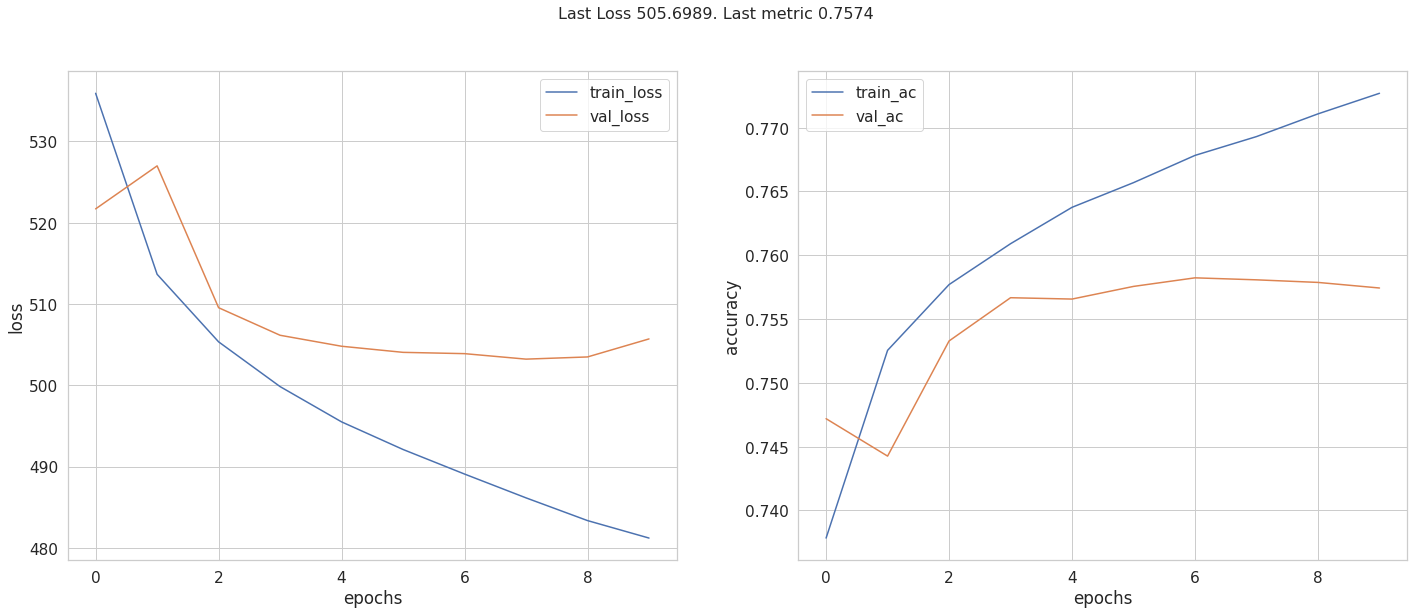

In [ ]:
model, dict_metrics = fit_model(model, optimizer, criterion, train_loader, valid_loader, epochs, model_name, device, start=1)

In [ ]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 2

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.FloatTensor(targets)}

In [ ]:
test_dev = ContextTwitterDataset(test_data, "text", "emotion", word2vec, unknown_embeddings)
test_loader = DataLoader(test_dev, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

In [ ]:
import torch.nn as nn
from torch.optim import Adam

vector_size = word2vec.vector_size
num_classes = 2
model = E2CModel(vector_size, num_classes)
criterion = nn.BCELoss(reduction='sum')
model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_context_model.pt')))
model = model.to(device)
print(testing(model, criterion, test_loader, device=device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


{'Test Loss': 504.15596481176993, 'Test Acc': 0.7579185802715654}


### Эмбеддинг TF-IDF

На тему применения TF-IDF в боевых условиях. У меня было несколько мыслей о том, как применять TF-IDF в этой задаче. В итоге, я решила, что к тестовому датасету нужно применять TF-IDF, обученный на dev_data, не смотря на то, что часть слов не будет найдена.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds


class TFIDF_embeddings():
    def __init__(self, data: pd.DataFrame, feature_column: str, vector_size: int):
        self.tokenizer = nltk.WordPunctTokenizer()
        self.data = data
        self.feature_column = feature_column
        self.vector_size = vector_size
        self.words = None 
        self.sw_matrix = None
        self.vectorize()
        self.embeddings = self.get_embeddings()
        self.vocabulary = self.get_vocabulary()
        self.mean = np.mean(self.embeddings, axis=0)
        self.std = np.std(self.embeddings, axis=0) 

    def preproc(self, text):
        line = self.tokenizer.tokenize(text.lower())
        filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
        return ' '.join(filtered_line)

    def vectorize(self):
        vectorizer = TfidfVectorizer(preprocessor=self.preproc, 
                                     lowercase=True,
                                     dtype=np.float32)
        self.sw_matrix = vectorizer.fit_transform(self.data[self.feature_column])
        self.words = vectorizer.get_feature_names_out()

    def get_embeddings(self):
        _, _, v = svds(self.sw_matrix, k=300, maxiter=100, return_singular_vectors="vh", tol=1e-3)
        return v.T

    def get_vocabulary(self):
        vocabulary = dict()
        for i, word in enumerate(self.words):
            vocabulary[word] = i
        return vocabulary

    def get_item(self, token):
        if token in self.vocabulary:
            index = self.vocabulary[token]
            embedding = (self.embeddings[index] - self.mean) / self.std
            return embedding
        return np.zeros((self.vector_size))

In [ ]:
tfidf_vectorizer = TFIDF_embeddings(dev_data, 'text', word2vec.vector_size)

In [ ]:
# Сохраним модель, чтобы в следующий раз быстрее загружать
import pickle
with open(os.path.join(DATA_DIR, 'tfidf_vectorizer.pickle'), 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle)

In [ ]:
# Загрузим tfidf_vectorizer
import pickle
with open(os.path.join(DATA_DIR, 'tfidf_vectorizer.pickle'), 'rb') as handle:
    tfidf_vectorizer = pickle.load(handle)

In [ ]:
from torch.utils.data import Dataset, random_split


class TFIDFTwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, 
                 feature_column: str, target_column: str, 
                 word2vec: gensim.models.Word2Vec,
                 tfidf_vectorizer: TFIDF_embeddings):
        self.tokenizer = nltk.WordPunctTokenizer()
        self.data = data
        self.feature_column = feature_column
        self.target_column = target_column
        self.word2vec = word2vec        
        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)
        self.tfidf_vectorizer = tfidf_vectorizer

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}

    def get_tokens_(self, text):
        # Получи все токены из текста и профильтруй их
        line = self.tokenizer.tokenize(text.lower())
        filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
        return filtered_line

    def get_mean_embedding(self, token):
        result = []
        emb_tf = self.tfidf_vectorizer.get_item(token)
        if np.sum(emb_tf):
          result.append(emb_tf)

        if token in self.word2vec:
            emb_w = ((self.word2vec.get_vector(token) - self.mean) / self.std).reshape(1, -1)
            result.append(emb_tf)

        if len(result):
          return np.mean(result, axis=0)
        return np.zeros((self.word2vec.vector_size)) 

    def get_embeddings_(self, tokens): 
        embeddings = [self.get_mean_embedding(w) for w in tokens if (w in self.word2vec) or (w in self.tfidf_vectorizer.vocabulary)] 
        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(1, -1)
        return embeddings

    def __len__(self):
        return self.data.shape[0]

In [ ]:
tfidf_dev = TFIDFTwitterDataset(dev_data, "text", "emotion", word2vec, tfidf_vectorizer)

In [ ]:
len(tfidf_dev)

1280000

In [ ]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 2

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.FloatTensor(targets)}


train_size = math.ceil(len(tfidf_dev) * 0.8)

train, valid = random_split(tfidf_dev, [train_size, len(tfidf_dev) - train_size])

train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=average_emb)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=average_emb)

In [ ]:
import torch.nn as nn
from torch.optim import Adam

vector_size = tfidf_dev.word2vec.vector_size
num_classes = 2
lr = 1e-3
epochs = 10
model_name = 'tfidf'

model = E2CModel(vector_size, num_classes)
model = model.to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = Adam(params=model.parameters(), lr=lr)


Epoch 011  train_loss: 518.7154      val_loss 544.6687  train_ac 0.7455  val_ac 0.7321


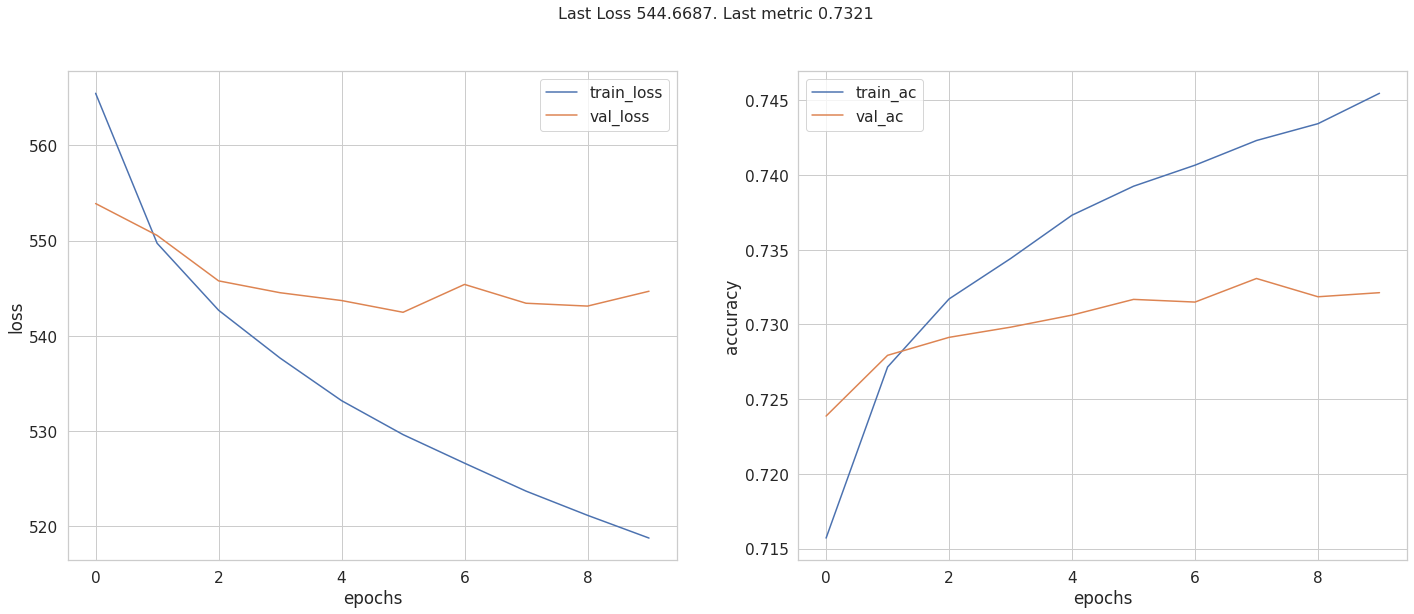

In [ ]:
model, dict_metrics = fit_model(model, optimizer, criterion, train_loader, valid_loader, epochs, model_name, device, start=1)

In [ ]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 2

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.FloatTensor(targets)}

In [ ]:
test_dev = TFIDFTwitterDataset(test_data, "text", "emotion", word2vec, tfidf_vectorizer)
test_loader = DataLoader(test_dev, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_tfidf_model.pt')))

print(testing(model, criterion, test_loader, device=device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


{'Test Loss': 548.4011107618436, 'Test Acc': 0.7319351537539937}


## Выводы
Сравним реализации:
* word2vec от gensim.
  * Простая реализация, быстрое обучение, Colab не отрубается в связи с исчерпанием ресурса ОЗУ
  * Показатели качества: 
      * 'Test Loss': 505.18
      * 'Test Acc': 0.756
* Незнакомые слова по контексту.
  * Несложная реализация (но немного сложнее, чем в первом случае), быстрое обучение, Colab отрубается в связи с исчерпанием ресурса ОЗУ (приходится итеративно перезапускаться с сохранением промежуточных результатов)
  * Показатели качества: 
      * 'Test Loss': 504.16
      * 'Test Acc': 0.758   
* TFIDF.
  * Сложная реализация (применение сразу 2 алгоритмов TFIDF и SVD), быстрое обучение, Colab отрубается в связи с исчерпанием ресурса ОЗУ (приходится итеративно перезапускаться с сохранением промежуточных результатов)
  * Показатели качества: 
      * 'Test Loss': 548.40
      * 'Test Acc': 0.732


Лучшие показатели имеют первый вариант и второй вариант с расчетом среднего вектора незнакомых слов по их контексту. 

Касательно полученных результатов или почему они получились не очень хорошими (мои мысли):
1. Модель word2vec училась на новостях, а классифицировали твиты. Предполагаю, что лексика предобученных эмбеддингов отличается от лексики исследуемого датасета.
2. Токенизация датасета твитов включала удаление пунктуации и коротких (меньше 4-х букв слов). Т.е. все смайлики были удалены, а они придают эмоциональный окрас предложению сильнее любых слов. В неформальном английском присутствуют определенные сокращения, которые также придают эмоциональную окраску предложений. Например WTF, которое было бы удалено в процессе предобработки.
3. Удаление стоп-слов фактически обеспечивается длиной слова при предобработке. Но есть и более длинные слова, у которых нет эмоциональной окраски. Например, they или journalist. В частности, bad journalist имеет негативную окраску, но из-за удаления слова bad, удаляется и окраска. А вот good journalist имеет положительную окраску, а слово good не удаляется. В итоге, наличие слова journalist в других предложениях, может дать неправильную подсказку модели.
4. Я обратила внимание, что в твиттах присутствуют тэги (т.е. указание никнейма человека, к которому обращаются). В модели word2vec вероятно большинство никнеймов будет отсутствовать (если это не какие-то известные люди вроде Маска или Трампа). Это приемлемо для первого варианта, когда мы не учитываем незнакомые слова, но, кажется, может негативно отразиться на результатах 2 и 3 вариантов, когда эти никнеймы приобретают какой-то свой эмбеддинг по контексту, в котором они встречаются. Думаю, что в задаче классификации эмоций следует аккуратно работать с никнеймами и пробовать различные подходы (включающие или исключающие никнеймы)
5. Когда мы используем TFIDF + SVD, то получаем эмбеддинги слов только на основе исследуемого датасета. Известные word2vec слова получают "дополнительную" информацию, а неизвестные - только информацию из исследуемого датасета. Судя по полученным результатам, конректно в этой задаче классификации эмоций, эта дополнительная информация не добавляет информативности об эмоциональной окраске целого предложения.
6. Когда незнакомые слова мы берем по среднему эмбеддингов контекста, то это очень напоминает "мешок слов" - свалили в кучу все слова, вместе с которыми встречается это незнакомое слово и усреднили. Возможно, данный подход добавляет немного информации в эмбеддинг текущего предложения из других, содержащих то же самое незнакомое слово, но, похоже, эта информация не слишком полезна. Например, если это самое незнакомое слово и формирует эмоциональный окрас всего предложения, тогда его контекст в любом предложении может быть неинформативен (с точки зрении эмоции). Возможно, незнакомое слово не имеет никакого эмоционального окраса, и его контекст, собранный из всех слов, в контексте с которыми встречалось данное слово, не добавляет этому слову эмоционального окраса (т.е. не влияет на информативность) или случайно добавляет не тот эмоциональный окрас, который был бы у предложения без использования эмбеддинга этого незнакомого слова.
7. Есть предложения, эмоциальный окрас которых даже человек не всегда может определить. Может быть так, что одно и то же предложение, сказанное разными людьми или в разном контексте переписки, может иметь принципиально разное значение и эмоциональный окрас. В этой задаче мы не знаем всех участников переписки, и не знаем о связи одних твиттов с другими (тогда здесь имеет значение, как была получена разметка эмоций). Например, 
    - Dad, I baked your favorite cake
    - Great! 
  * Или 
    - Dad, I broke your car :-(
    - Great!

Слово great имеет абсолютно разное значение в этих двух случаях (Пример умышленно тривиален, чтобы объяснить мою мысль в этом пункте). 
8. Думаю, для того, чтобы качественно сравнить все 3 подхода нужно более глубоко исследовать результаты:
  - На каких сэмплах ошибаются все модели (могу ли я, как человек, определить эмоцию этого предложения)
  - На каких сэмплах ошибаются последние 2 модели, а первая нет? Содержат ли эти предложения незнакомые word2vec слова? Что это за слова?
  - Если использовать другие варианты предобработки, например, оставлять смайлики, не удалять короткие слова, удалять стоп-слова, будут ли отличаться результаты моделей?
  - Если учить модели на большем количестве эпох, взвешивать лосс и т.д., будет ли новый фаворит?

К сожалению, данное исследование требует значительных временных ресурсов, которыми я не располагаю.

В целом, подходы с вычислением эмбеддингов незнакомых слов мне понравились, считаю, что они достаточно полезны, и их стоит тестировать в других задачах (если в этой задаче не взлетело, это не значит, что подходы бесполезны).